In [1]:
# just some useful functions, imports and settings

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from datetime import datetime
def time_string():
    # return datetime.now().strftime("%d %B %Y %X")
    return datetime.now().strftime("%X")
impath = 'trash_img'    # path to the folder to save pictures
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (8, 6),
    'figure.dpi': 200
})

# useful functions

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        # print(v,'+-',er)
        pass
    approx_label = f"approximation by {fun_name}"
    if (err == np.inf).any():
        print("Approximation didn't converge. Try to set initial param values p0")
    else:
        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    teorPoints = 50     
    indent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*indent, b+(b-a)*indent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"area of {nsigma} $\sigma$ error")

def make_beautiful_plot(xname, xunit, yname, yunit):
    plt.grid(True, which='minor', linewidth=0.2)
    plt.grid(True, which='major')
    if len(xunit) != 0:
        plt.xlabel(fr"{xname} ({xunit})")
    else:
        plt.xlabel(fr"{xname}")
    if len(yunit) != 0:
        plt.ylabel(fr"{yname} ({yunit})")
    else:
        plt.ylabel(fr"{yname}")
    plt.title(fr"{yname}({xname})")
    plt.legend()

## 8
Metropolis numerical integration algorithm.

In [2]:
np.random.seed(42)

In [3]:
from collections.abc import Callable

In [4]:
   
def model_dist(N: int, 
               distribution_func: Callable[[float], float], 
               max_delta, 
               step_dist:Callable[[float], float]=(lambda delta: np.random.uniform(-delta, delta)), 
               init_value=0,
               return_frac=False) -> np.array:
    if distribution_func(init_value) <= 0:
        raise ValueError("Init value probability is invalid")
    
    series = np.zeros(N)
    series[0] = init_value
    
    accepted_steps = 0
    all_steps = 0
    
    for i in range(N-1):
        x_i = series[i]
        x_try = x_i + step_dist(max_delta)
        all_steps += 1
        if min(1, distribution_func(x_try)/distribution_func(x_i)) < np.random.rand():
            series[i+1] = x_i
        else:
            series[i+1] = x_try
            accepted_steps += 1
    if return_frac:
        return series, accepted_steps/all_steps
    return series

In [5]:
def exp_dist(x, h=1):
    return (x>0)*np.exp(-h*x)*h

## Testing histogram

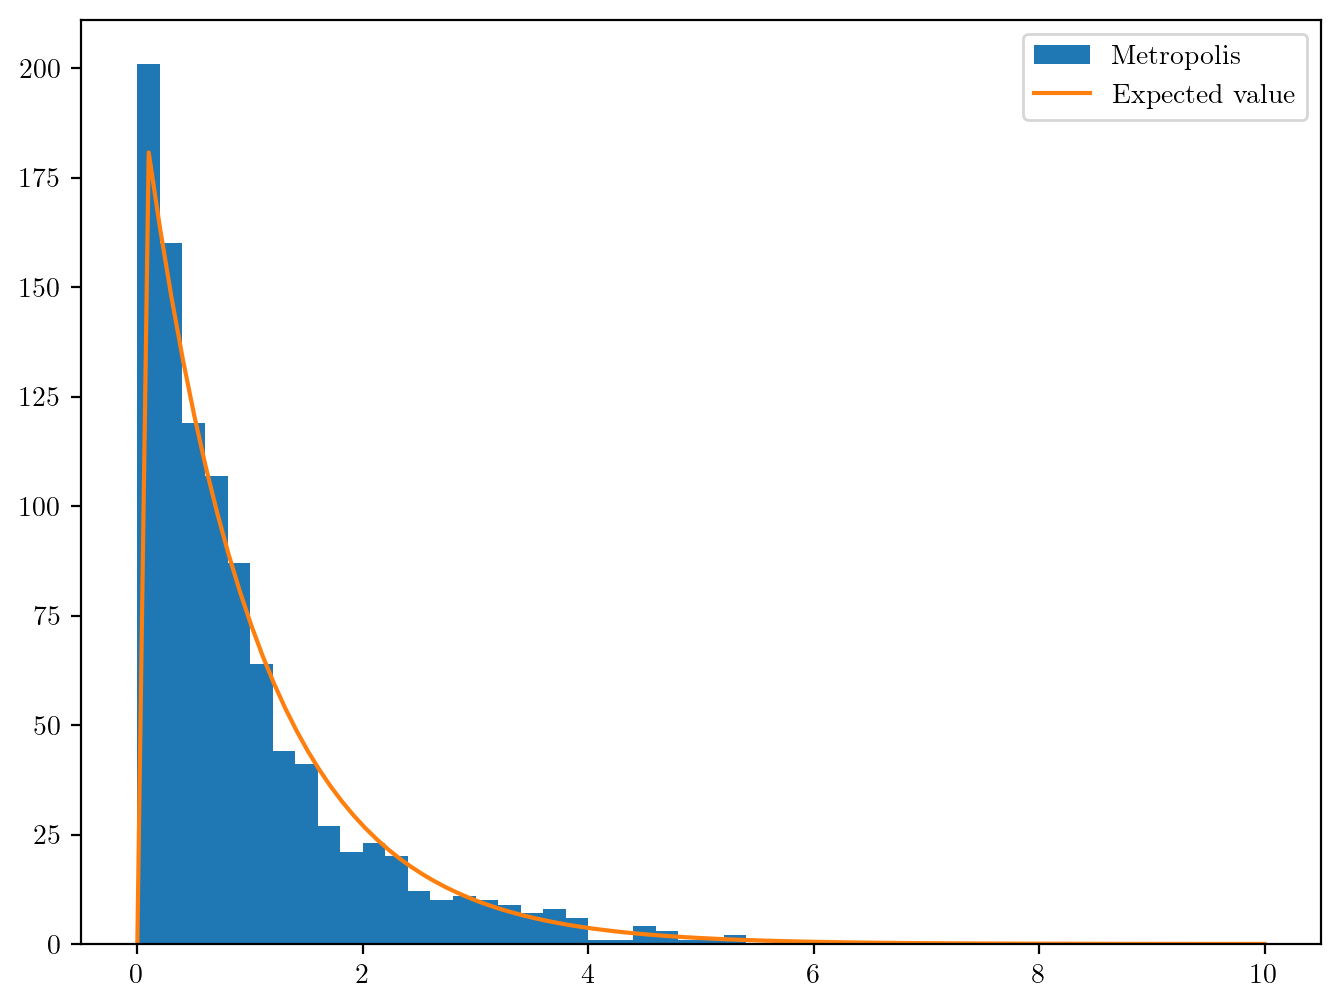

In [6]:
series = model_dist(1000, exp_dist, 1, init_value=1)
# ignored warm up and dropping first 300 values, because chose init_value as expected value of distribution

dx=0.2
vis_area = (0, 10)
# plt.hist(series, vis_area, bins=(vis_area[1]-vis_area[0])/dx)
plt.hist(series, bins=np.arange(vis_area[0], vis_area[1], dx), label="Metropolis")

x = np.linspace(vis_area[0], vis_area[1], 100)
y = exp_dist(x)*len(series)*dx
plt.plot(x, y, label="Expected value")
plt.legend()
None

Integrands are samples uniformly enough.

### Average evaluation

In [7]:
results = []
for _ in range(20):
    x = model_dist(1000, exp_dist, 1, init_value=1)
    average = np.sum(x**2) / np.sum(np.ones_like(x))
    results.append(average)
results = np.array(results)

mean = results.mean()
error = np.sqrt((np.mean(results**2)-mean**2)/(len(results)-1))    

print(f"<X^2> = {mean} +- {error}")

<X^2> = 2.216770408306335 +- 0.16990428536646676


### B

analytical value is

$$ <x^2> = \frac{\Gamma (3)}{\Gamma (1)}= \frac{2 \cdot 1}{1} = 2$$

Result agrees in couple of $\sigma$-s interval, but error is quite big for 20 thousand points in total.

In [8]:
def numb_formatter(val):
    return f'{val:.2f}'

In [9]:
text = []
value = []
errors = []
accept_rates = []
ns = [250, 2500]
dels = [0.1, 1, 10]

for n in ns:
    for d in dels:
        results = []
        accepted_fracs = []
        for _ in range(50):
            x, frac = model_dist(n, exp_dist, d, init_value=1, return_frac=True)
            average = np.sum(x**2) / np.sum(np.ones_like(x))
            results.append(average)
            accepted_fracs.append(frac)
        results = np.array(results)
        mean = results.mean()
        error = np.sqrt((np.mean(results**2)-mean**2))  
        
        text.append(f"n = {n}, d = {d}")  
        errors.append(error)
        value.append(mean)
        accept_rates.append(np.mean(accepted_fracs))

compare_table = pd.DataFrame(
    {"description":text,
     "value":value, 
     "standard deviation":errors, 
     "tries accepting rate": accept_rates}
    )
compare_table.style.hide(axis="index").format({"standard deviation": numb_formatter, 
                                               "value": numb_formatter,
                                               "tries accepting rate": numb_formatter})

description,value,standard deviation,tries accepting rate
"n = 250, d = 0.1",1.17,0.84,0.97
"n = 250, d = 1",2.03,1.33,0.64
"n = 250, d = 10",1.96,1.01,0.10
"n = 2500, d = 0.1",1.56,1.66,0.95
"n = 2500, d = 1",1.98,0.56,0.63
"n = 2500, d = 10",1.99,0.36,0.10


For n = 250, $\delta = 0.1$ is too small to get far from initial position, so value is far from theoretical 2, although standard deviation in this case is quite small. This means, that in case of n=250, $\delta = 0.1$ standard deviations is not reasonable estimate of error. It happens, because standard deviation shows deviation from mean value, while in this case mean doesn't equal true theoretical value. 

With higher steps value is better, but standard deviation of results is very high.

For n = 2500 standard deviation is smaller. And standard deviation decreased with increasing of $\delta$.

# Correlation time.

I will use n = 1000 and $\delta = 1$ in this experiment.

In [10]:
N = 10
j_range = np.arange(1, 50)
C = np.zeros((len(j_range), N), dtype=np.float64)
for k in range(N):
    series = model_dist(1000, exp_dist, 1, init_value=1)
    st_dev = np.sqrt((series**2).mean() - series.mean()**2)
    for i, j in enumerate(j_range):
        correl = (series[j:]*series[:-j]).mean() - series.mean()**2
        C[i, k] = correl/st_dev

C = C.mean(axis=1)

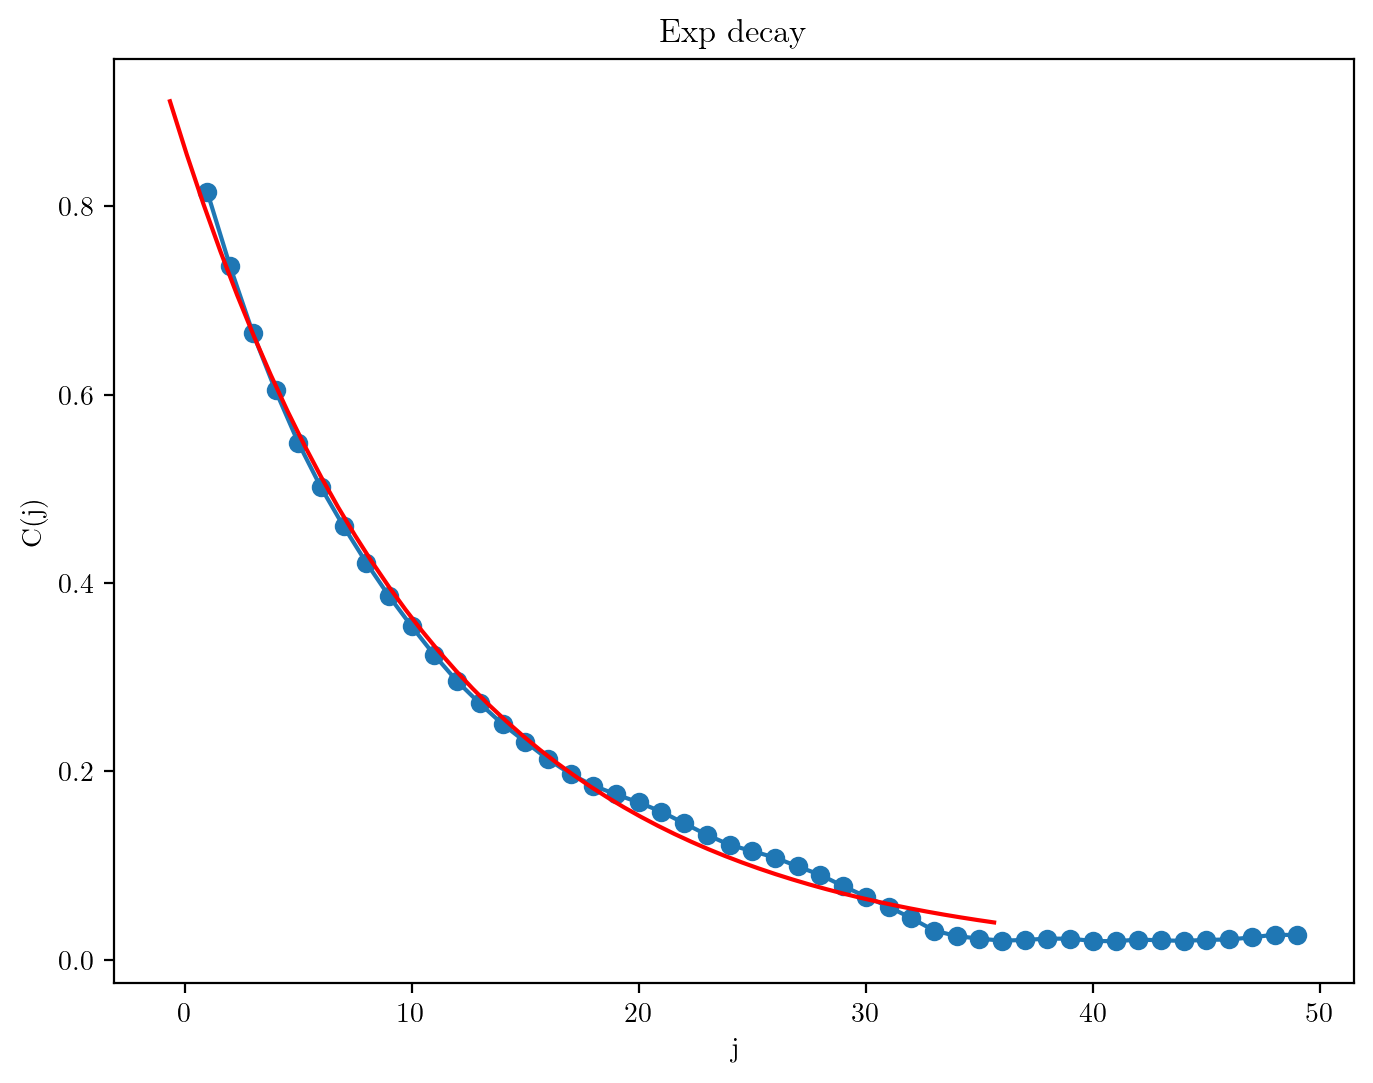

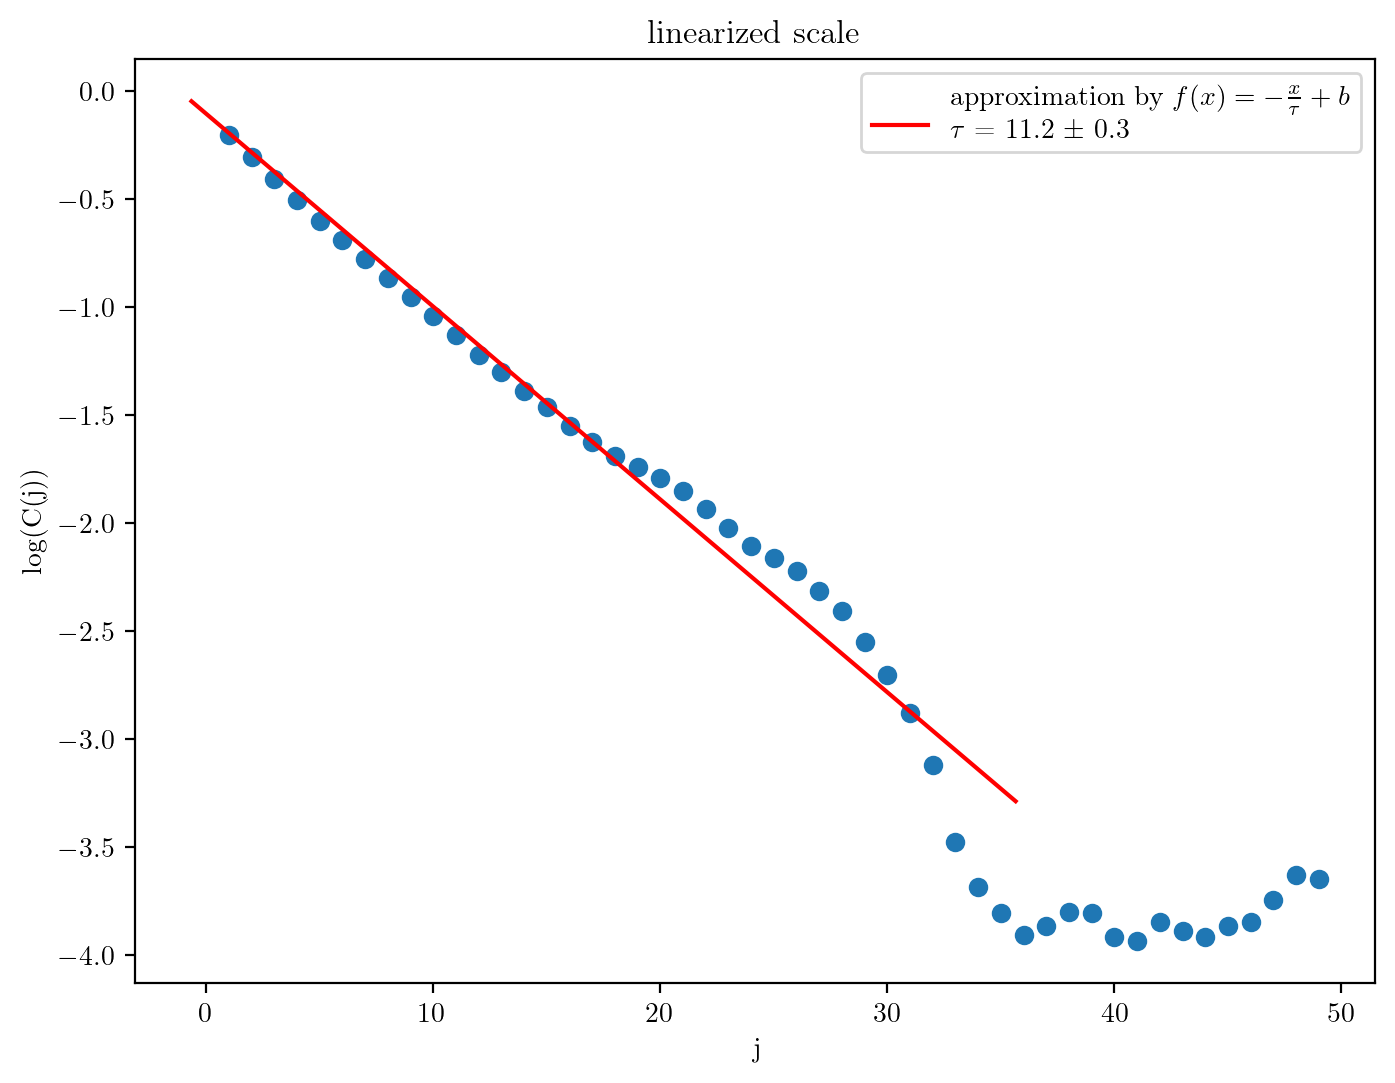

In [11]:
plt.plot(j_range, C, 'o-')
plt.xlabel('j')
plt.ylabel('C(j)')
plt.title("Exp decay")

# function to approximate
fun_name = r"$f(x) = \exp (-\frac{x}{\tau} + b)$"
def f(x, k, b):
    return np.exp(b - x/k)
par_names_str = fr'''
$\tau$, 
'''
filter = j_range<35
plot_approx(j_range[filter], C[filter], f, par_names_str, fun_name, visApproxError=False)
# plt.legend()
plt.show()



plt.plot(j_range, np.log(C), 'o')
plt.xlabel('j')
plt.ylabel('log(C(j))')
plt.title("linearized scale")

# function to approximate
fun_name = r"$f(x) = -\frac{x}{\tau} + b$"
def f(x, k, b):
    return b - x/k
par_names_str = fr'''
$\tau$, 
'''
filter = j_range<35
plot_approx(j_range[filter], np.log(C)[filter], f, par_names_str, fun_name, visApproxError=False)
plt.legend()

None

Estimation of correletion time is: \
$\tau \approx 11.2 \pm 0.3$